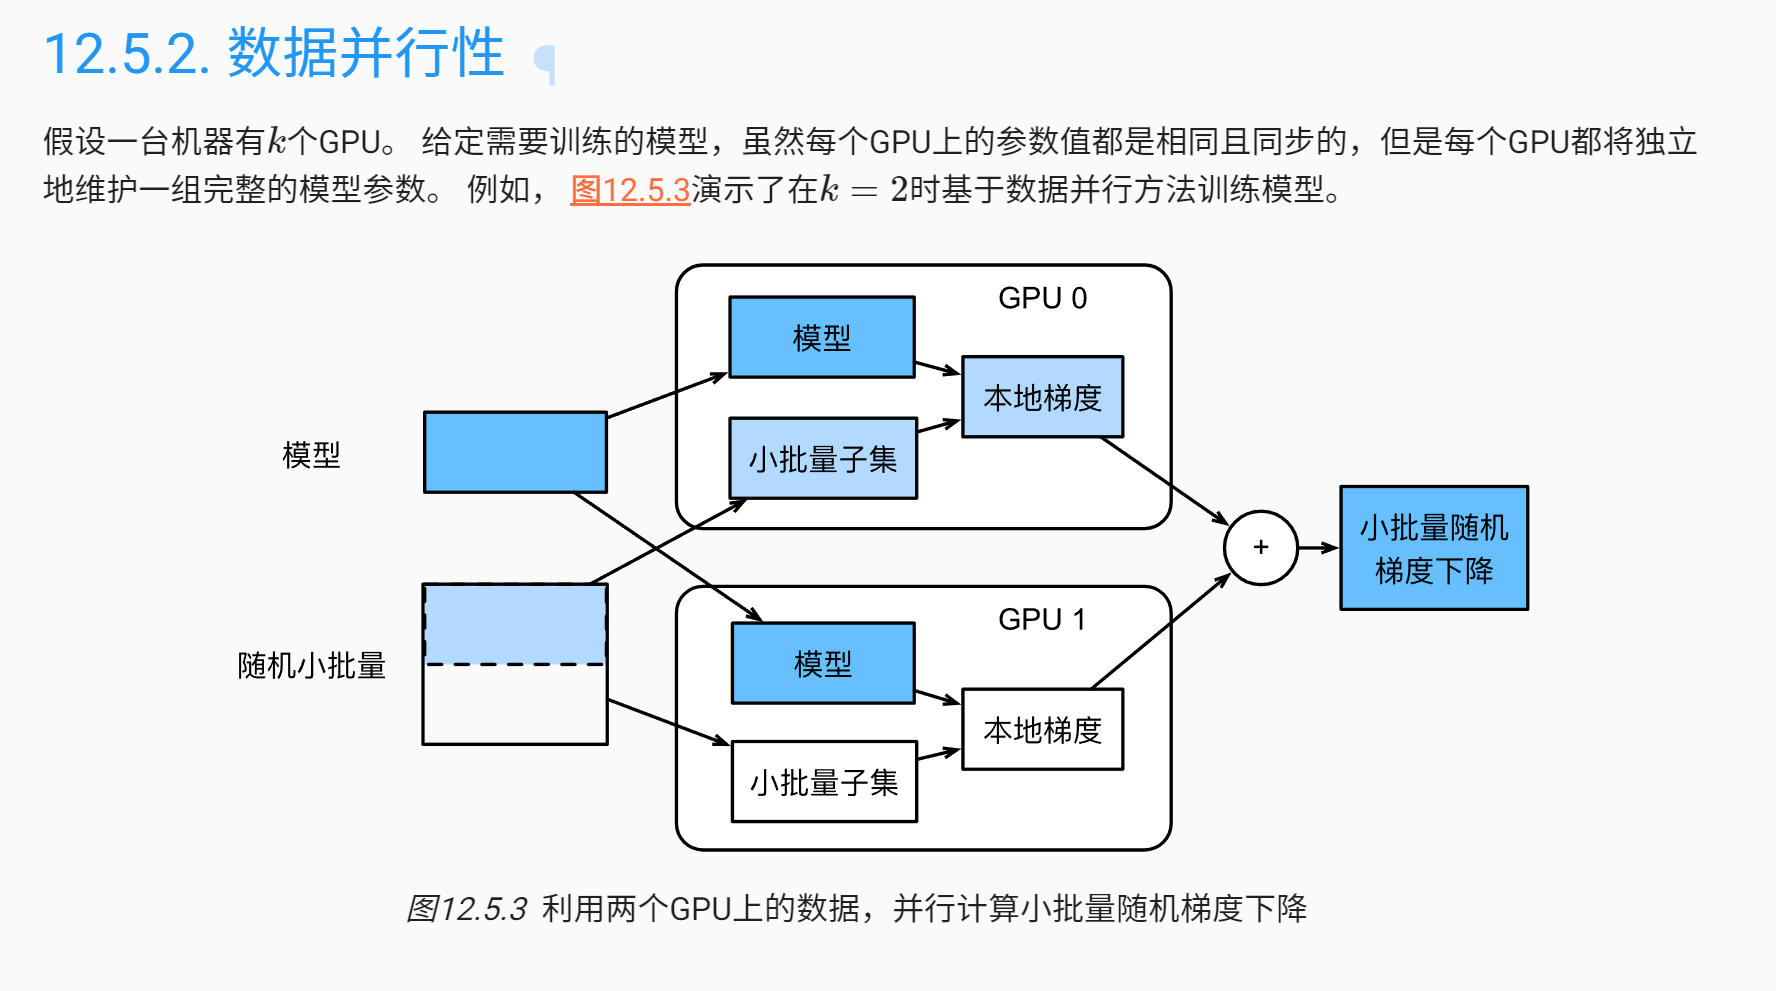

In [5]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [6]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [7]:
# 4.数据同步
# 我们需要向多个设备分发参数并附加梯度
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [8]:
# 通过将模型参数复制到一个GPU
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
b1 梯度: None


In [9]:
# 由于还没有进行任何计算，因此权重参数的梯度仍然为零。 
# 假设现在有一个向量分布在多个GPU上，下面的allreduce函数将所有向量相加，并将结果广播给所有GPU。 
# 请注意，我们需要将数据复制到累积结果的设备，才能使函数正常工作。
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)


In [10]:
# 通过在不同设备上创建具有不同值的向量并聚合它们。
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]]) 
 tensor([[2., 2.]])
allreduce之后：
 tensor([[3., 3.]]) 
 tensor([[3., 3.]])


In [11]:
# 5.数据分发
# 我们需要一个简单的工具函数，将一个小批量数据均匀地分布在多个GPU上
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

AttributeError: module 'torch._C' has no attribute '_scatter'

In [ ]:
# 为了方便以后复用，我们定义了可以同时拆分数据和标签的split_batch函数
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

In [ ]:
# 6.训练
# 现在我们可以在一个小批量上实现多GPU训练
# 在多个GPU之间同步数据将使用刚才讨论的辅助函数allreduce和split_and_load
# 我们不需要编写任何特定的代码来实现并行性。 因为计算图在小批量内的设备之间没有任何依赖关系，因此它是“自动地”并行执行。
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量